# Matrimonios por día 

This dataset includes a very basic data resource to display volume of marriage license issuances by the Guilford County Register of Deeds office from July 1, 2012 to December 18, 2018.

https://data.world/guilfordcounty/15f377df-8a43-4c06-b3dc-bcffd704b528

In [ ]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
matplotlib.rcParams['figure.figsize'] = [16,5]
import warnings
warnings.filterwarnings("ignore")

# Graficar una serie a partir de un dataset relevante. Describir observaciones.

In [2]:
period=90

inputfile="both_sexes.csv"
print('Input file is:', inputfile)
df = pd.read_csv(inputfile)
df = df.set_index(pd.DatetimeIndex(df['RecDate']))
df.sort_index(ascending=True, inplace=True)
df["Count"] = 1
df = df["Count"]

Input file is: both_sexes.csv


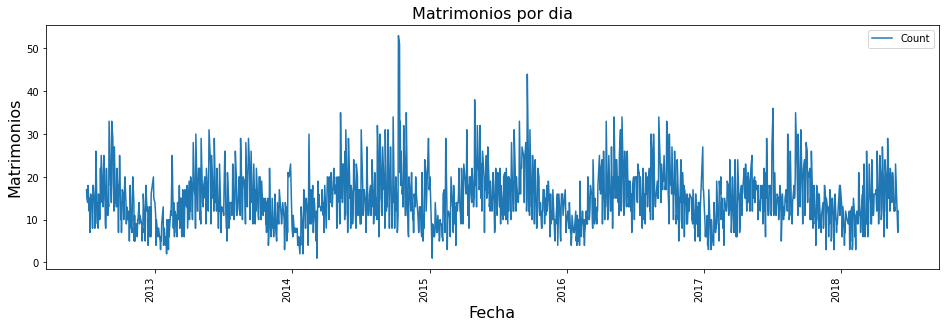

In [3]:
matplotlib.rcParams['figure.figsize'] = [16,5]
plt.figure()
ax = df.groupby("RecDate").count().plot(y='Count', rot=90)
ax.set_title("Matrimonios por dia", fontsize=16)
ax.set_ylabel("Matrimonios", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)
plt.legend(loc='best')
plt.show()

### La evolución de la cantidad de matrimonios a través de los años presenta cierta estabilidad, a pesar de los picos observables. A simple vista tiene una estacionalidad del tipo anual. Con picos mínimos anuales de como máximo 10 casamientos y con picos de entre 30 y  50 casamientos.

# Descomponer una serie de tiempo usando el modelo aditivo de cuatro componentes

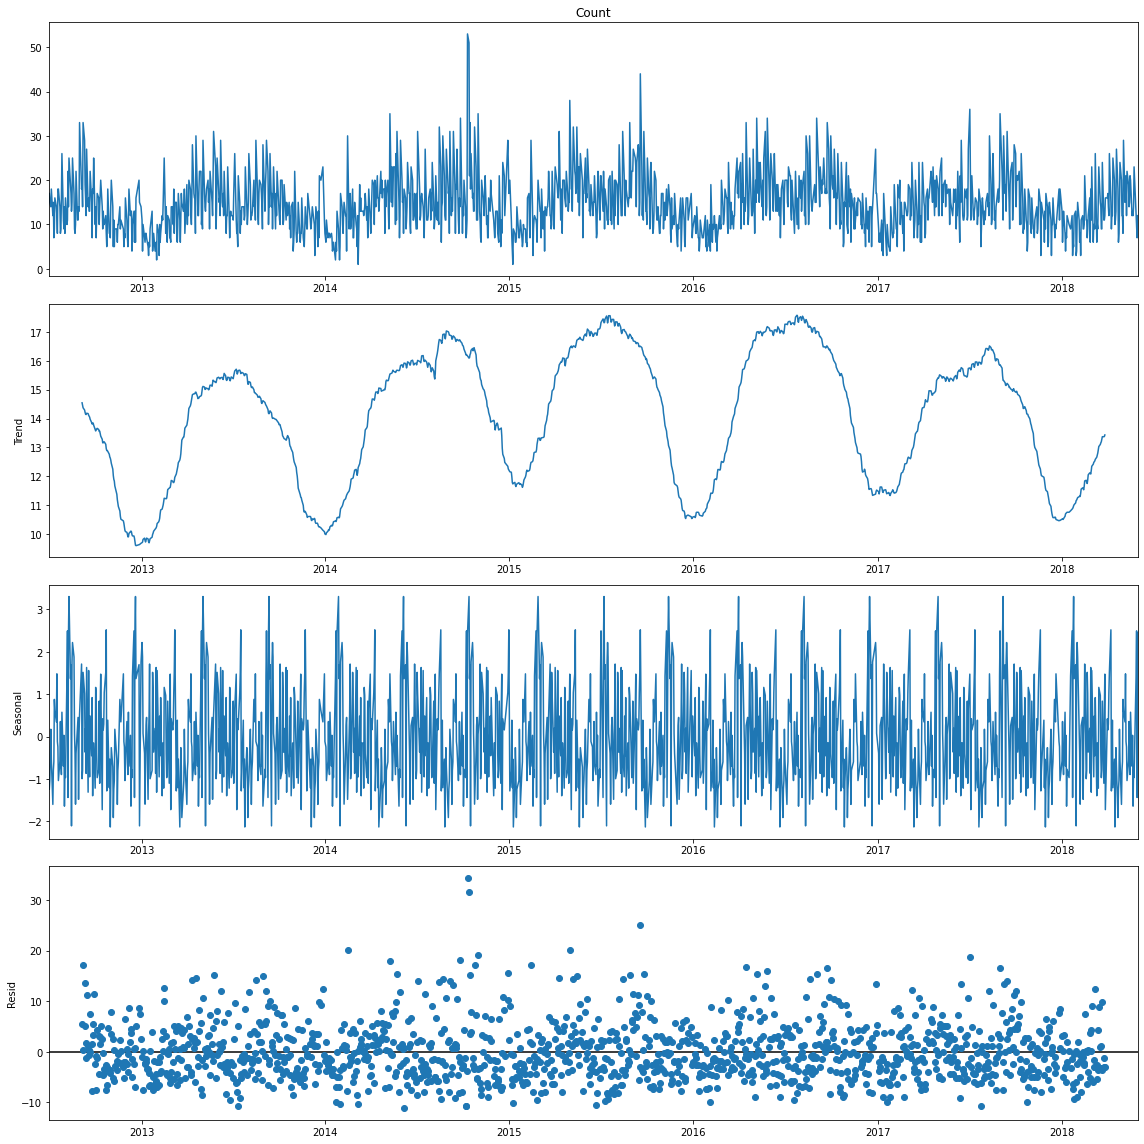

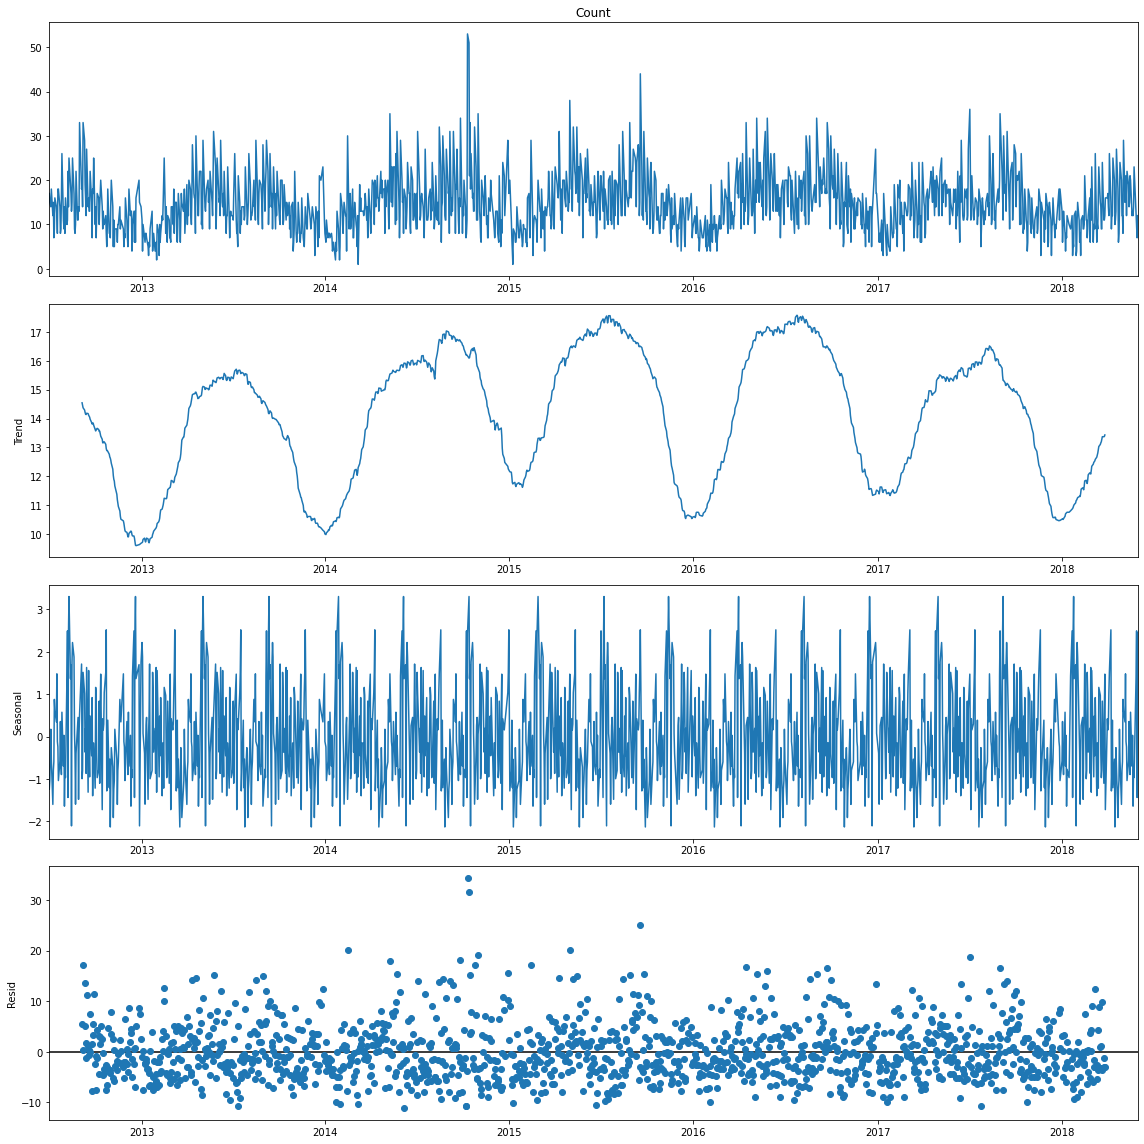

In [4]:
matplotlib.rcParams['figure.figsize'] = [16,16]
df = df.groupby("RecDate").count()
addit = sm.tsa.seasonal_decompose(df, model='additive', period=period)
addit.plot()

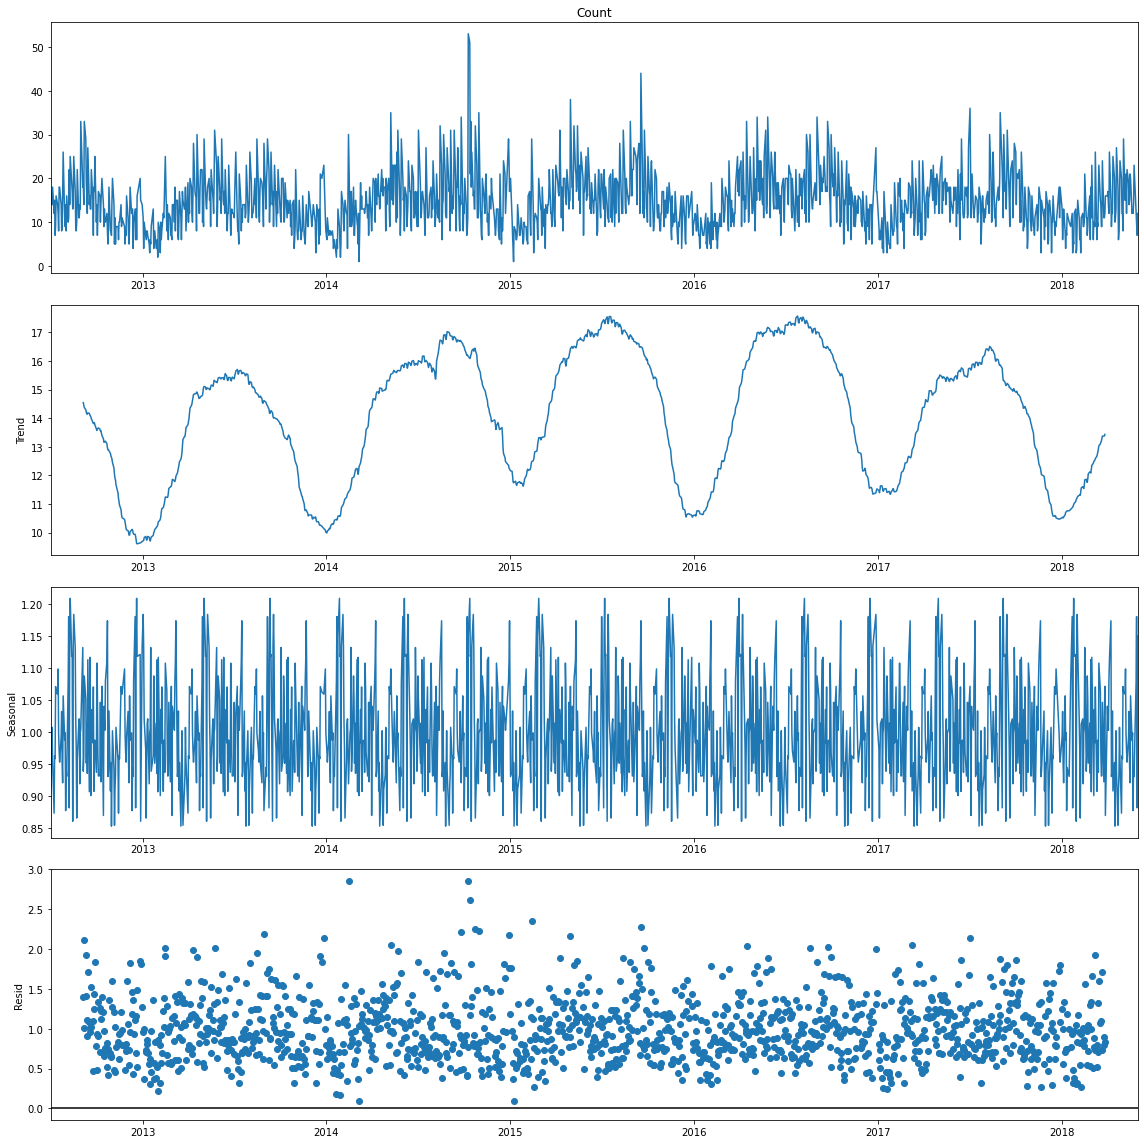

In [5]:
# Multiplicative
mult = sm.tsa.seasonal_decompose(df, model='multiplicative', period=period)
mult.plot(); plt.show()

# Extraer la tendencia y ajustar un modelo determinístico. Explicar su relación con el contexto. Obtener conclusiones acerca de la validez del modelo.

### Tendencia:

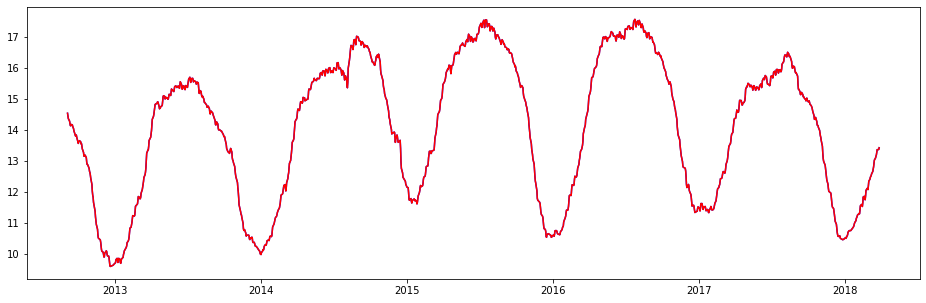

In [6]:
matplotlib.rcParams['figure.figsize'] = [16,5]
period=90
addit = sm.tsa.seasonal_decompose(df, model='additive', period=period)
mult = sm.tsa.seasonal_decompose(df, model='multiplicative', period=period)
plt.plot(addit.trend, color="blue")
plt.plot(mult.trend, color="red")
plt.show()

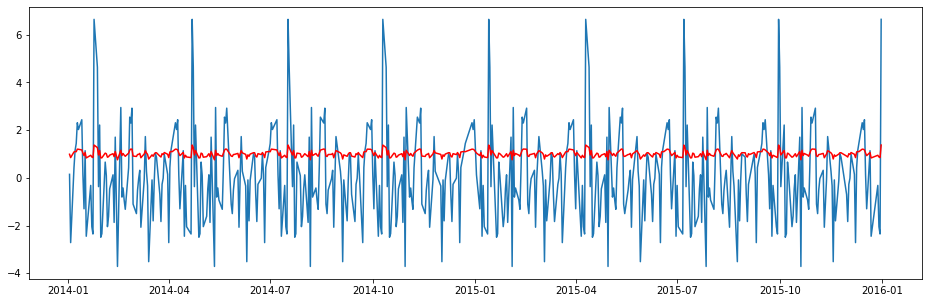

In [7]:
# viendo solo 3 años para observar mejor
matplotlib.rcParams['figure.figsize'] = [16,5]
period=60
temp_df = df["2014":"2015"]
addit = sm.tsa.seasonal_decompose(temp_df, model='additive', period=period)
mult = sm.tsa.seasonal_decompose(temp_df, model='multiplicative', period=period)
plt.plot(addit.seasonal)
plt.plot(mult.seasonal, color="red")
plt.show()

Al ver la descomposición de la serie, se puede observar una tendencia anual clara, que a comienzo del año empieza a crecer y a partir de la mitad del año empieza a decrecer.
También se puede ver que tiene una clara estacionalidad fuerte a pesar de tener mucho ruido.

# Ajustar un modelo determinístico

## Ajustando un modelo determinístico cíclico

In [8]:
sig = df.reset_index().Count
N = 367 # days
sample = 2 # years

dataframe = pd.Series(sig)
ts = pd.DataFrame(dataframe.values)
rows = int(len(ts)/N)
data = ts.values.reshape(rows, N)
betas = data.mean(axis=0)
est = np.tile(betas,rows)

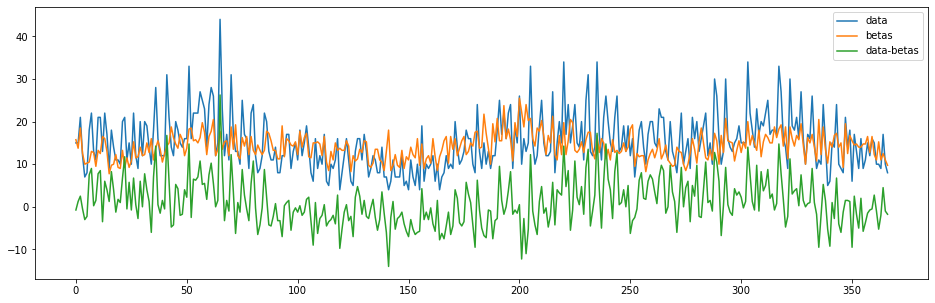

In [9]:
plt.plot(data[sample,:])
plt.plot(betas)
plt.plot(data[sample,:]-betas)
plt.legend(['data','betas','data-betas'])
plt.show()

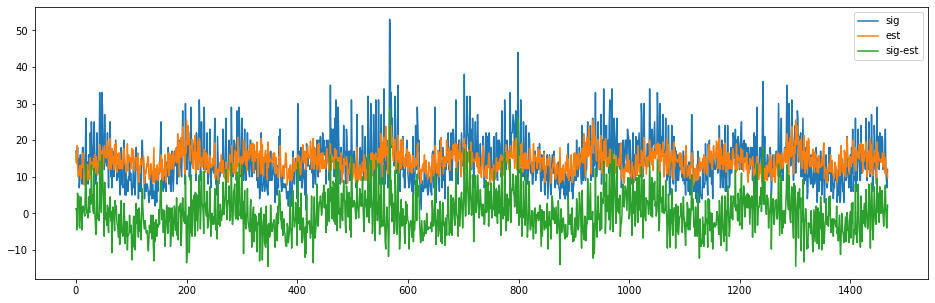

In [10]:
plt.plot(sig)
plt.plot(est)
plt.plot(sig-est)
plt.legend(['sig','est','sig-est'])
# plt.legend(['sig','est'])
plt.show()

Como a simple vista se veían los ciclos anuales, un modelo cíclico con un N de 365 dias ajusta bastante bien al modelo.

## Ajustando un modelo con polyfit

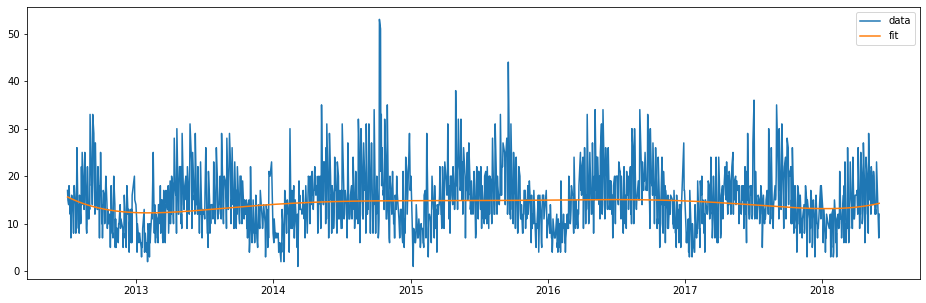

In [11]:
x = mdates.date2num(df.index)
f = 1/4

poly = np.polyfit(x, df, deg=6)

fig, ax = plt.subplots()
ax.plot(df, label='data')
ax.plot(df.index, np.polyval(poly, x), label='fit')
ax.legend()

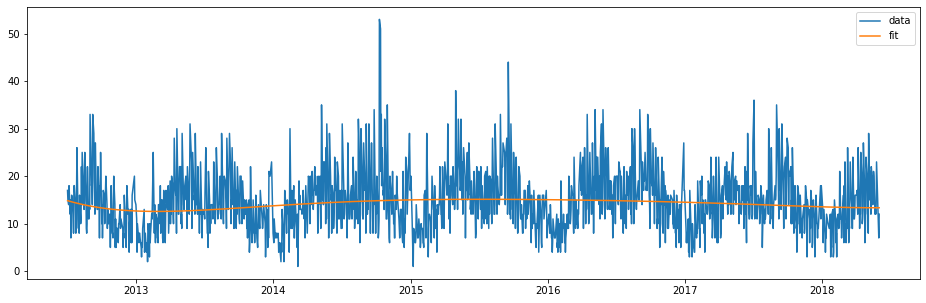

In [12]:
def objective(x, a, b, c, d, e, f, g):
    return a * x**6 + b * x**5 + c * x**4 + d * x**3 + e * x**2 + f * x + g

x = mdates.date2num(df.index)
popt, _ = curve_fit(objective, x, df)

a, b, c, d, e, f, g = popt

y_line = objective(x, a, b, c, d, e, f, g)

fig, ax = plt.subplots()
plt.plot(df, label="data")
plt.plot(df.index, y_line, label="fit")
ax.legend()

Ajustando un modelo polinómico, queda básicamente como la media. No se aprecian los ciclos marcados como se esperaba.